# Menghubungkan google colab ke grive


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Import Library


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
    ConfusionMatrixDisplay,
)

## Membaca Data CSV


In [3]:
df = pd.read_csv("/content/gdrive/MyDrive/ML3/praktikum/praktikum04/Data/stunting_wasting_dataset.csv")
df.head()

,Jenis Kelamin,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting,Wasting
0,Laki-laki,19,91.6,13.3,Tall,Risk of Overweight
1,Laki-laki,20,77.7,8.5,Stunted,Underweight
2,Laki-laki,10,79.0,10.3,Normal,Risk of Overweight
3,Perempuan,2,50.3,8.3,Severely Stunted,Risk of Overweight
4,Perempuan,5,56.4,10.9,Severely Stunted,Risk of Overweight


## Melihat informasi umum dataset

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Jenis Kelamin      100000 non-null  object 
 1   Umur (bulan)       100000 non-null  int64  
 2   Tinggi Badan (cm)  100000 non-null  float64
 3   Berat Badan (kg)   100000 non-null  float64
 4   Stunting           100000 non-null  object 
 5   Wasting            100000 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 4.6+ MB


# Data Pre-processing
Tahap ini bertujuan untuk menyiapkan data agar dapat digunakan oleh model machine learning. Pada
regresi logistik, model hanya bisa menerima data dalam bentuk numerik, sehingga kolom kategorik
seperti Jenis Kelamin dan Stunting harus diubah (di-encode) menjadi angka terlebih dahulu. Selain itu,
tahap ini juga memastikan tidak ada nilai kosong (missing value) dan memeriksa hubungan
antarvariabel.

## Cek Missing Value
Perintah ini digunakan untuk memastikan apakah terdapat data yang hilang pada setiap kolom. Hasil
menunjukkan seluruh kolom (Jenis Kelamin, Umur, Tinggi, Berat, Stunting, Wasting) memiliki nilai 0
pada jumlah missing value. Artinya, tidak ada data kosong, sehingga dataset dapat langsung
digunakan tanpa proses imputasi.

In [5]:
df.isnull().sum()

,0
Jenis Kelamin,0
Umur (bulan),0
Tinggi Badan (cm),0
Berat Badan (kg),0
Stunting,0
Wasting,0


##  Cek Nilai Unik
1. Kolom Stunting memiliki 4 kategori: Tall, Stunted, Normal, Severely Stunted.
2. Kolom Jenis Kelamin memiliki 2 kategori: Laki-laki dan Perempuan.
3. Karena target prediksi (stunting) bersifat biner (ya/tidak), maka kategori ini akan
disederhanakan menjadi dua kelas:
• 1 → Stunted / Severely Stunted
• 0 → Normal / Tall

In [6]:
df['Stunting'].unique()

array(['Tall', 'Stunted', 'Normal', 'Severely Stunted'], dtype=object)

In [7]:
df['Jenis Kelamin'].unique()

array(['Laki-laki', 'Perempuan'], dtype=object)

## Mapping Kolom Kategorik ke Bentuk Numerik
Kode di atas mengubah nilai teks menjadi bentuk numerik agar dapat diproses model.
• Kolom baru Stunting_bin digunakan sebagai target (Y).
• Kolom JK_bin digunakan sebagai fitur (X) tambahan.
• Hasil distribusi:
o Stunting_bin → 78.021 data tidak stunting (0) dan 21.979 data stunting (1).
o JK_bin → 50.179 laki-laki (1) dan 49.821 perempuan (0).
• Distribusi ini menunjukkan data relatif seimbang antara laki-laki dan perempuan, namun kelas
“stunting” lebih sedikit dibanding “tidak stunting”.

In [8]:
# Maping kolom Stunting -> biner
map_stunt = {'Stunted':1, 'Saverely Stunted':1, 'Normal':0, 'Tall':0}
df['Stunting_bin'] = df['Stunting'].map(map_stunt).astype('Int64')

# 2. Maping Kolom Jenis kelamin -> biner
#  Laki-laki=1, perempuan =0
df['JK_bin'] =(df['Jenis Kelamin'] == 'Laki-laki').astype(int)
print("Distribusi Stunting_bin:\n", df['Stunting_bin'].value_counts())
print("\nDistribusi JK_bin:\n", df['JK_bin'].value_counts())

Distribusi Stunting_bin:
 Stunting_bin
0    78021
1    16160
Name: count, dtype: Int64

Distribusi JK_bin:
 JK_bin
1    50179
0    49821
Name: count, dtype: int64


## Analisis Korelasi Antar Variabel Numerik
Fungsi corr() digunakan untuk menghitung korelasi Pearson antara setiap variabel numerik terhadap
target Stunting_bin.

Nilai korelasi berkisar antara -1 hingga 1:
• Nilai mendekati 1 → hubungan positif kuat (naik bersama)
• Nilai mendekati -1 → hubungan negatif kuat (berlawanan arah)
• Nilai mendekati 0 → hubungan lemah atau tidak ada hubungan

In [9]:
corr_matrix = df.corr(numeric_only=True)
corr_matrix

,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting_bin,JK_bin
Umur (bulan),1.000000,0.875869,0.665389,0.061955,0.004046
Tinggi Badan (cm),0.875869,1.000000,0.626005,-0.224156,0.073505
Berat Badan (kg),0.665389,0.626005,1.000000,0.037797,0.045797
Stunting_bin,0.061955,-0.224156,0.037797,1.000000,-0.009779
JK_bin,0.004046,0.073505,0.045797,-0.009779,1.000000


## Visualisasi Heatmap Korelasi
Visualisasi heatmap korelasi digunakan untuk melihat hubungan antar variabel numerik secara
menyeluruh dalam dataset. Dengan heatmap, kita dapat mengetahui variabel mana yang memiliki
korelasi kuat, sedang, atau lemah, serta arah hubungannya (positif atau negatif) terhadap variabel
target Stunting_bin

<function matplotlib.pyplot.show(close=None, block=None)>

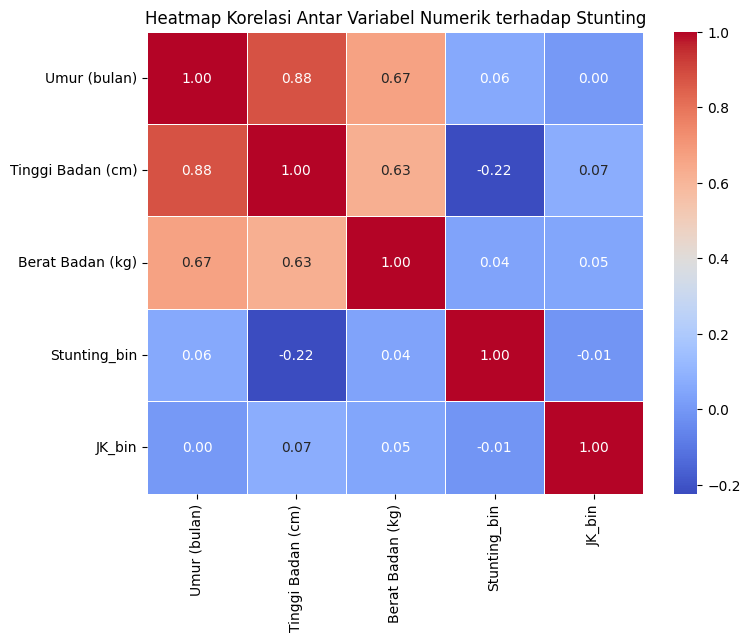

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap Korelasi Antar Variabel Numerik terhadap Stunting", fontsize=12)
plt.show

# Pembagian Dataset (Training dan Testing)

## Menentukan Fitur dan Target


In [11]:
feature_num = ['Umur (bulan)', 'Tinggi Badan (cm)', 'Berat Badan (kg)']
feature_bin = ['JK_bin']

# Gabungkan & drop missing
use_cols = feature_num + feature_bin + ['Stunting_bin']
df_model = df[use_cols].dropna().copy()

X = df_model[feature_num + feature_bin]
y = df_model['Stunting_bin']

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (94181, 4)
y shape: (94181,)


## Membagi Dataset menjadi Training dan Testing Set


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print("Data latih:", X_train.shape)
print("Data uji:", X_train.shape)

Data latih: (75344, 4)
Data uji: (75344, 4)


# Pembangunan Model Logistic Regression


In [13]:
# Scale hanya fitur numerik, gender Langsung passthrough
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), feature_num),
        ('bin', 'passthrough', feature_bin)
    ],
    remainder='drop'
)

model = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    class_weight='balanced',
    random_state=42
)

clf = Pipeline([
    ('preprocess', preprocess),
    ('model', model)
])

# Latih model
clf.fit(X_train, y_train)
print("✅ Model Logistic Regression berhasil dilatih.")

✅ Model Logistic Regression berhasil dilatih.


# Prediksi Model dan Evaluasi Model


In [14]:
# Prediksi & probabilitas
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# Hitung metrik
print(f"Akurasi    : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision  : {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"Recall     : {recall_score(y_test, y_pred, zero_division=0):.4f}")
print(f"F1-Score   : {f1_score(y_test, y_pred, zero_division=0):.4f}")
print(f"ROC-AUC    : {roc_auc_score(y_test, y_prob):.4f}")

Akurasi    : 0.8943
Precision  : 0.6252
Recall     : 0.9579
F1-Score   : 0.7566
ROC-AUC    : 0.9599


# Visualisasi Hasil Evaluasi


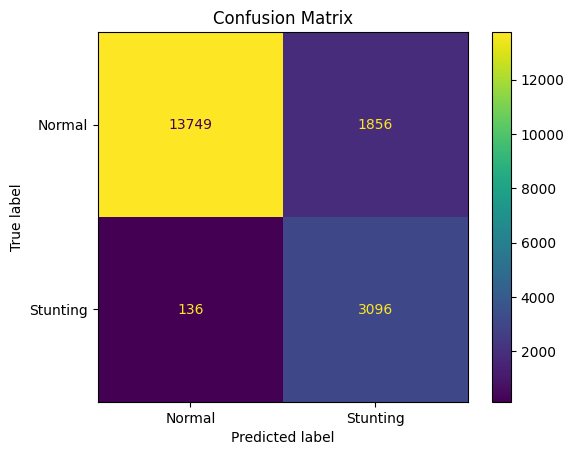

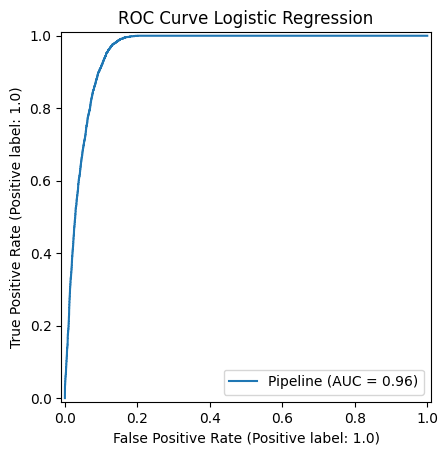

In [15]:
# Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred),
                       display_labels=['Normal', 'Stunting']
                       ).plot(values_format='d')
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("ROC Curve Logistic Regression")
plt.show()

# Classification Report


In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['Tidak Stunting (0)', 'Stunting (1)']))

                    precision    recall  f1-score   support

Tidak Stunting (0)       0.99      0.88      0.93     15605
      Stunting (1)       0.63      0.96      0.76      3232

          accuracy                           0.89     18837
         macro avg       0.81      0.92      0.84     18837
      weighted avg       0.93      0.89      0.90     18837



# Classification Report


In [17]:
from sklearn.model_selection import cross_val_score

# Lakukan cross validation (cv=5 berarti 5-fold)
scores = cross_val_score(clf, X, y, cv=5)

# Tampilkan hasil
print("Skor tiap fold:", scores)
print("Rata-rata akurasi:", np.mean(scores))
print("Standar deviasi:", np.std(scores))

Skor tiap fold: [0.89531242 0.88978552 0.89360798 0.88718412 0.88898917]
Rata-rata akurasi: 0.8909758408110315
Standar deviasi: 0.0030157913854655903


# . Interpretasi Model Logistic Regression


In [18]:
# Ambil nama fitur & koefisien
feat_names = feature_num + feature_bin
coefs = clf.named_steps['model'].coef_[0]
odds = np.exp(coefs)

coef_df = pd.DataFrame({
    'Fitur': feat_names,
    'Koefisien (log-odds)': coefs,
    'Odds Ratio (e^coef)': odds
}).sort_values('Odds Ratio (e^coef)', ascending=False)

display(coef_df)

,Fitur,Koefisien (log-odds),Odds Ratio (e^coef)
0,Umur (bulan),8.310390,4065.897805
3,JK_bin,1.627485,5.091057
2,Berat Badan (kg),0.629313,1.876321
1,Tinggi Badan (cm),-10.161155,0.000039


# Prediksi Data Baru (Contoh Kasus)


In [19]:
# Contoh 2 anak
data_baru = pd.DataFrame({
    'Umur (bulan)': [24, 10],
    'Tinggi Badan (cm)': [79.0, 72.5],
    'Berat Badan (kg)': [9.2, 7.8],
    'JK_bin': [1, 0] # 1=Laki-Laki, 0=Perempuan
})

pred = clf.predict(data_baru)
prob = clf.predict_proba(data_baru)[:,1]

hasil = data_baru.copy()
hasil['Prob_Stunting'] = prob
hasil['Pred (0=Tidak,1=Ya)'] = pred
display(hasil)

,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),JK_bin,Prob_Stunting,"Pred (0=Tidak,1=Ya)"
0,24,79.0,9.2,1,0.998298,1.0
1,10,72.5,7.8,0,0.003024,0.0
